In [1]:
csv_path = "/home/ali/Datasets/Fitz17k/fitzpatrick17k_preprocessed.csv"
csv_pred_path = "/home/ali/Outputs/Fitzpatrick17k/XTranPrune_baseline_High/validation_results_DiT_S_LRP_level=high_epoch=50_random_holdout.csv"
main_br_path = "/home/ali/Outputs/Fitzpatrick17k/XTranPrune_baseline_High/DiT_S_LRP_level=high_checkpoint_BASE.pth"
SA_br_path = "/home/ali/Outputs/Fitzpatrick17k/XTranPrune_SABranch_Binary/DiT_S_LRP_2SABranch_checkpoint.pth"
root_image_dir = "/home/ali/Datasets/Fitz17k/Images/"

# Visualization code

In [2]:
import os
import skimage
from skimage import io
import torch
import pandas as pd
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd


In [3]:
def generate_visualization(attribution_generator, original_image, class_index=None):

    transformer_attribution = attribution_generator.generate_LRP(
        input=original_image.unsqueeze(0).cuda(),
        method="transformer_attribution",
        index=class_index,
    )[0].detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(
        transformer_attribution, scale_factor=16, mode="bilinear"
    )
    transformer_attribution = (
        transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    )
    transformer_attribution = (
        transformer_attribution - transformer_attribution.min()
    ) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (
        image_transformer_attribution - image_transformer_attribution.min()
    ) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


In [4]:
import sys
sys.path.append('..') 
from Datasets.datasets import SkinDataset

fitz_dataset = SkinDataset(
        df=pd.read_csv(csv_path),
        root_dir=root_image_dir,
        transform=transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(size=256),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        ),
    )

In [25]:
from Models.ViT_LRP import deit_small_patch16_224

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

main_model = deit_small_patch16_224(
    pretrained=False,
    num_classes=3,
    add_hook=True,
    weight_path=main_br_path,
)
main_model = main_model.eval().to(device)

SA_model = deit_small_patch16_224(
    pretrained=False,
    num_classes=2,
    add_hook=True,
    weight_path=SA_br_path,
)
SA_model = SA_model.eval().to(device)

Weights loaded from /home/ali/Outputs/Fitzpatrick17k/XTranPrune_baseline_High/DiT_S_LRP_level=high_checkpoint_BASE.pth
Weights loaded from /home/ali/Outputs/Fitzpatrick17k/XTranPrune_SABranch_Binary/DiT_S_LRP_2SABranch_checkpoint.pth


# Visualization

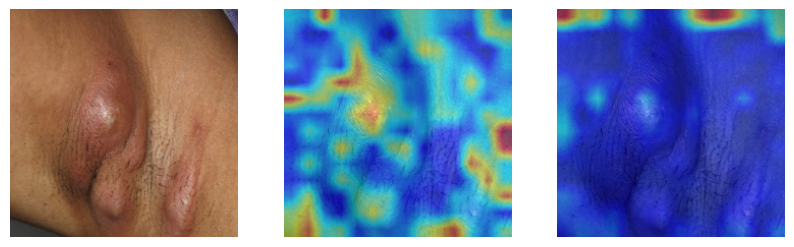

In [37]:
sample = fitz_dataset[326]
image = sample["image"]
label = sample["high"]
fitz = sample["fitzpatrick_binary"]

main_vis = generate_visualization(main_model, image, class_index=label)
SA_vis = generate_visualization(SA_model, image, class_index=fitz)


image = Image.open(os.path.join(root_image_dir, sample['hasher']+".jpg"))
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image = simple_transform(image).permute(1, 2, 0)

fig, axs = plt.subplots(1, 3, figsize=(10, 30))
axs[0].imshow(image);
axs[0].axis("off");
axs[1].imshow(main_vis);
axs[1].axis("off");
axs[2].imshow(SA_vis);
axs[2].axis("off");

In [14]:
df = pd.read_csv(csv_path)
df
indices = []
for fitz in range(6):
  filtered_df = df[df["fitzpatrick"]==fitz]
  indices.append(random.choice(filtered_df.index))

In [8]:
indices = [0,1,2,3,4,5]

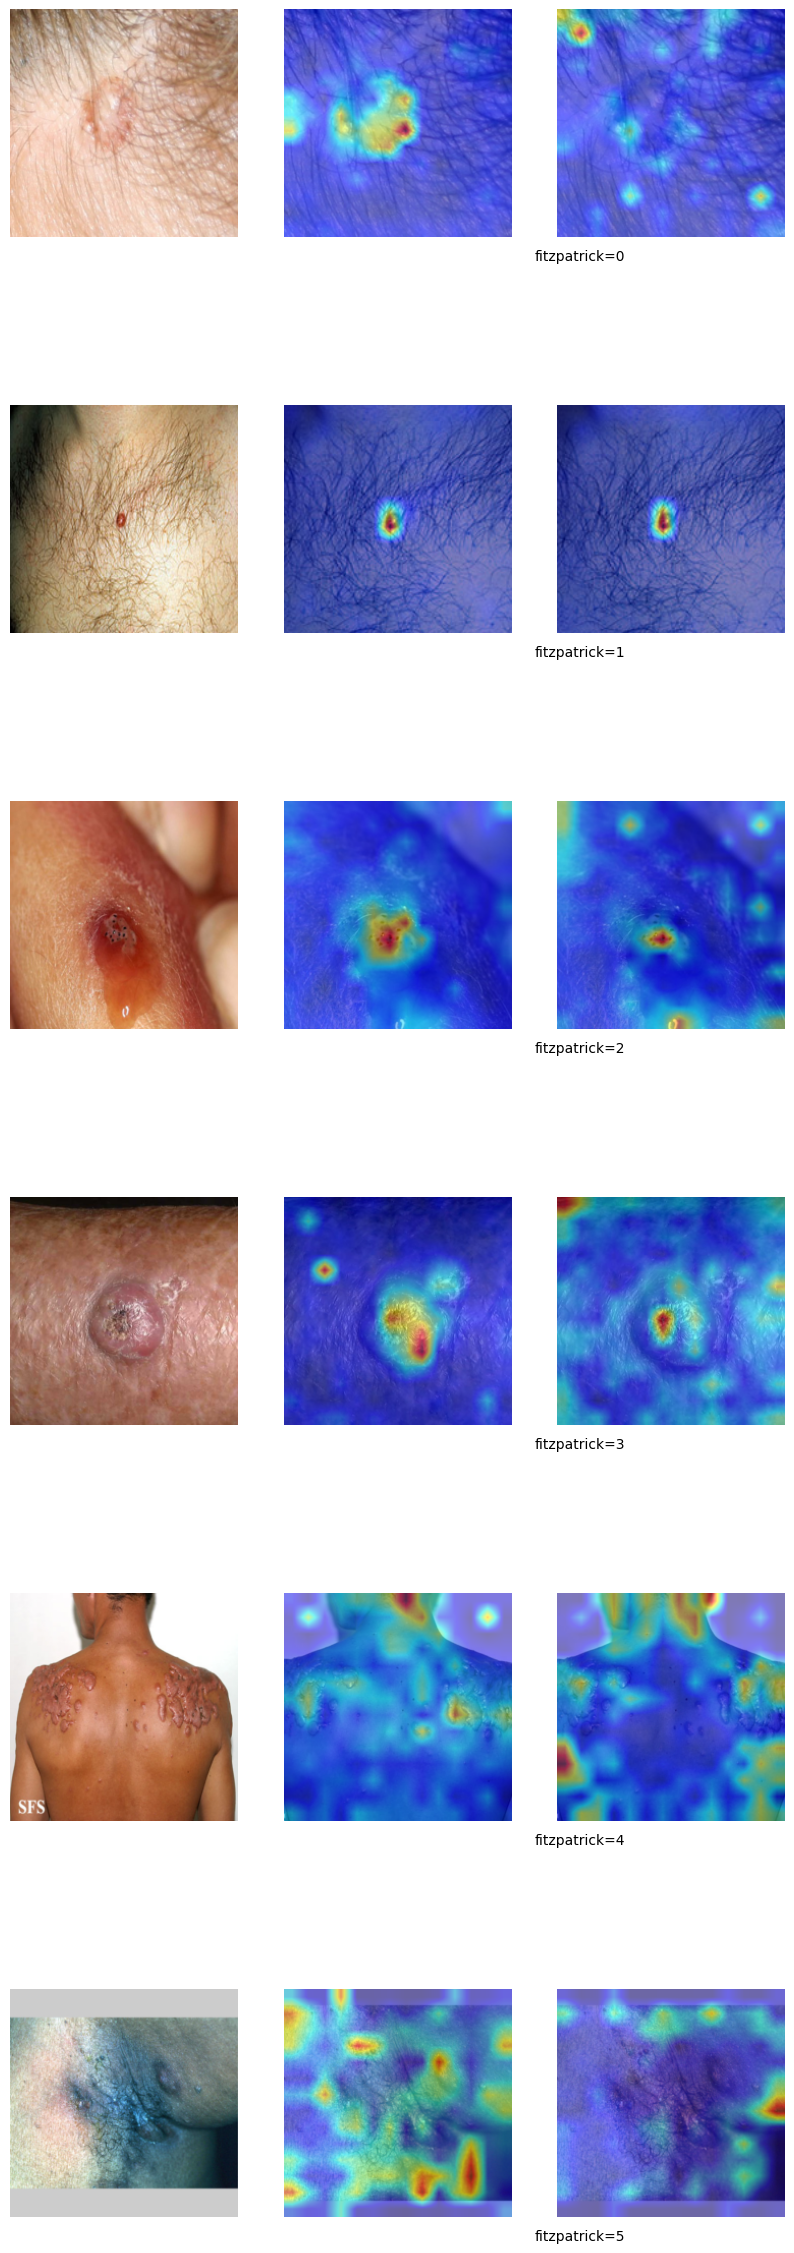

In [15]:
df = pd.read_csv(csv_path)
df
indices = []
for fitz in range(6):
  filtered_df = df[df["fitzpatrick"]==fitz]
  indices.append(random.choice(filtered_df.index))

fig, axs = plt.subplots(6, 3, figsize=(10, 30))
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


for i, idx in enumerate(indices):
  sample = fitz_dataset[idx]
  image = sample["image"]
  label = sample["high"]
  fitz = sample["fitzpatrick_binary"]


  main_vis = generate_visualization(main_model, image, class_index=label)
  SA_vis = generate_visualization(SA_model, image, class_index=fitz)


  image = Image.open(os.path.join(root_image_dir, sample['hasher']+".jpg"))
  image = simple_transform(image).permute(1, 2, 0)

  axs[i][0].imshow(image);
  axs[i][0].axis("off");
  axs[i][1].imshow(main_vis);
  axs[i][1].axis("off");
  axs[i][2].imshow(SA_vis);
  axs[i][2].axis("off");
  axs[i][0].text(2.5, -0.1, "fitzpatrick={}".format(sample["fitzpatrick"]), transform=axs[i][0].transAxes, ha="center");

# Comparing Visualizations betweem subgroups

In [17]:
df_pred = pd.read_csv(csv_pred_path)
df=pd.read_csv(csv_path)

In [18]:
SA6_false = df_pred.loc[(df_pred['fitzpatrick']==5) & (df_pred['prediction'] == df_pred['label'])]
false_black_smpl = SA6_false.iloc[3]
original_idx = df.loc[df['hasher'] == false_black_smpl['hasher']].index[0]
false_black_smpl

hasher                    bc05a42bd1fdf389e3f18c3fc6a1c880
label                                                    2
fitzpatrick                                              5
fitzpatrick_binary                                       1
fitzpatrick_scale                                        6
prediction_probability                            0.999093
prediction                                               2
Name: 71, dtype: object

In [19]:
sample = fitz_dataset[original_idx]
hasher = sample["hasher"]
image = sample["image"]
label = sample["high"]
fitz = sample["fitzpatrick_binary"]

print(f"hasher={hasher}, label={label}, fitzpatrick={fitz}")

hasher=bc05a42bd1fdf389e3f18c3fc6a1c880, label=2, fitzpatrick=1


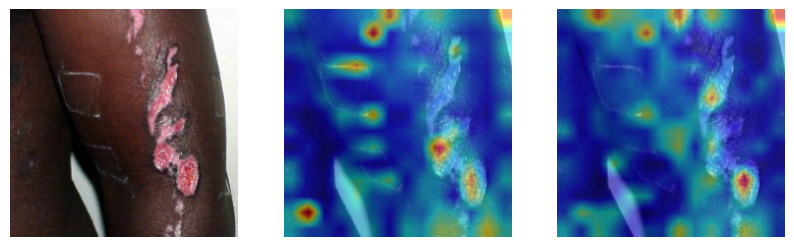

In [20]:
main_vis = generate_visualization(main_model, image, class_index=torch.tensor([label]))
SA_vis = generate_visualization(SA_model, image, class_index=torch.tensor([fitz]))
image = Image.open(os.path.join(root_image_dir, sample['hasher']+".jpg"))
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image = simple_transform(image).permute(1, 2, 0)

fig, axs = plt.subplots(1, 3, figsize=(10, 30))
axs[0].imshow(image);
axs[0].axis("off");
axs[1].imshow(main_vis);
axs[1].axis("off");
axs[2].imshow(SA_vis);
axs[2].axis("off");

# ViT-CX

In [33]:
sample = fitz_dataset[326]
hasher = sample["hasher"]
image = sample["image"]
label = sample["high"]
fitz = sample["fitzpatrick_binary"]

print(f"hasher={hasher}, label={label}, fitzpatrick={fitz}")
# print(original_idx)

hasher=a51640213be4c550f316af2ef17b1db9, label=2, fitzpatrick=1


In [34]:
from Explainability.ViT_CX.ViT_CX import ViT_CX
from Models.ViT_LRP import deit_small_patch16_224

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

main_model = deit_small_patch16_224(
    pretrained=False,
    num_classes=3,
    add_hook=True,
    weight_path=main_br_path,
)
main_model = main_model.eval().to(device)

SA_model = deit_small_patch16_224(
    pretrained=False,
    num_classes=2,
    add_hook=True,
    weight_path=SA_br_path,
)
SA_model = SA_model.eval().to(device)

target_layer=main_model.blocks[-1].norm1

# Perform ViT-CX
main_vis = ViT_CX(
    model=main_model,
    image=image.unsqueeze(0),
    target_layer=main_model.blocks[-1].norm1,
    target_category=label,
    distance_threshold=0.1,
    gpu_batch=50,
    num_classes=3,
)

SA_vis = ViT_CX(
    model=SA_model,
    image=image.unsqueeze(0),
    target_layer=SA_model.blocks[-1].norm1,
    target_category=fitz,
    distance_threshold=0.1,
    gpu_batch=50,
    num_classes=2,
)

Weights loaded from /home/ali/Outputs/Fitzpatrick17k/XTranPrune_baseline_High/DiT_S_LRP_level=high_checkpoint_BASE.pth
Weights loaded from /home/ali/Outputs/Fitzpatrick17k/XTranPrune_SABranch_Binary/DiT_S_LRP_2SABranch_checkpoint.pth
number of masks after the clustering:39


/home/ali/miniconda3/envs/XTranPrune_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/ali/miniconda3/envs/XTranPrune_env/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


number of masks after the clustering:42


/home/ali/miniconda3/envs/XTranPrune_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/ali/miniconda3/envs/XTranPrune_env/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


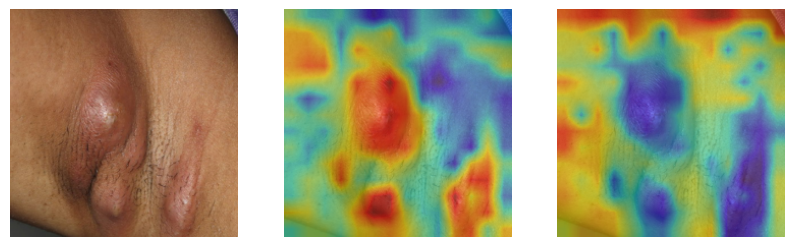

In [35]:
img = Image.open(os.path.join(root_image_dir, sample['hasher']+".jpg"))
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img = simple_transform(img).permute(1, 2, 0)

fig, axs = plt.subplots(1, 3, figsize=(10, 30))
axs[0].imshow(img);
axs[0].axis("off");
axs[1].imshow(img);
axs[1].imshow(main_vis, cmap='jet', alpha=0.5);
axs[1].axis("off");
axs[2].imshow(img);
axs[2].imshow(SA_vis, cmap='jet', alpha=0.5);
axs[2].axis("off");
